NOTE:THE EXPLANATION OF THE CODE BELOW IS IN THE BLOF POST:

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import numpy as np
import scipy.misc
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input,Lambda,Conv2D
from keras.models import load_model,Model
from yolo_utils import read_classes,read_anchors,generate_colors,preprocess_image,draw_boxes,scale_boxes
from yad2k.model.keras_yolo import yolo_head,yolo_boxes_to_corners,preprocess_true_boxes,yolo_loss,yolo_body

C:\Users\IRONMAN\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Applying YOLO filter functions

In [3]:
def yolo_filter_boxes(box_confidence,boxes,box_class_prob,threshold=0.6):
    #box_confidence:Probabilites of containing some object
    #boxes:Size of the boxes
    #box_class_prob:containing the detection probabilites of 80 classes
    #Box scores or class probabilites
    box_scores=np.multiply(box_confidence,box_class_prob)
    #Finding the index of the class with maximum probabilities
    box_classes=K.argmax(box_scores,axis=-1)
    #Finding the value of the class with maximum probabilites
    box_class_scores=K.max(box_scores,axis=-1)
    
    filtering_mask=K.greater_equal(box_class_scores,threshold)
    #Applying the mask to scores,boxes and classes
    scores=tf.boolean_mask(box_class_scores,filtering_mask)
    boxes=tf.boolean_mask(boxes,filtering_mask)
    classes=tf.boolean_mask(box_classes,filtering_mask)
    
    return scores,boxes,classes

# Non-max Suppression


In [4]:
def yolo_non_max_suppression(scores,boxes,classes,max_boxes=10,iou_threshold=0.5):
    max_boxes_tensor=K.variable(max_boxes,dtype="int32")
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    
    rms_indices=tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold=iou_threshold)
    
    scores=K.gather(scores,rms_indices)
    boxes=K.gather(boxes,rms_indices)
    classes=K.gather(classes,rms_indices)
    return scores,boxes,classes

# Putting things together [applying both filtering function Implemented above]

In [5]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes=yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes,iou_threshold=iou_threshold)
   
    return scores, boxes, classes

# Starting a Session

In [6]:
sess=K.get_session()

# Loading information about the anchor boxes and 80-classes

In [7]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)      

In [8]:
#Loading yolo model weights
yolo_model=load_model("model_data/yolo.h5")

C:\Users\IRONMAN\Anaconda3\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

# Transforming the YOLO outputs to be inputted to our yolo_eval function

In [ ]:
#As per Explained in the Blog
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [ ]:
#Applying our filtering (yolo_eval) function
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [ ]:
#Time to make prdictions 
#RUN TIME=FUN TIME!
def predict(sess, image_file):
    # Preprocess your image
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    out_scores,out_boxes,out_classes=sess.run([scores,boxes,classes],feed_dict={yolo_model.input:image_data,K.learning_phase():0})
   

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join( image_file), quality=90)
    # Display the results in the notebook
    output_image = scipy.misc.imread(image_file)
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

In [ ]:
#Resizing our own Images!To be inputted to the model!!
#Before executing this cell put your image in the images folder
from PIL import Image
image=Image.open("images\\ + your image file name")
image=image.resize((1280,720), Image.ANTIALIAS)
imshow(image)
image.save('images\\ + your image file name')

Found 2 boxes for images/my.jpg
person 0.72 (711, 357) (746, 420)
car 0.84 (1073, 379) (1280, 447)


C:\Users\IRONMAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


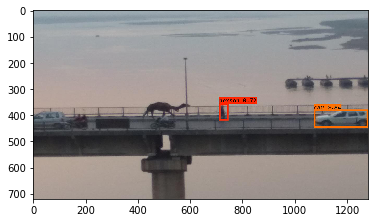

In [17]:

out_scores, out_boxes, out_classes = predict(sess, "images\\ + your image file name")

# Conculsion

That's all with Implementing Object Detection using YOLOv2 with Tensorflow and Keras.For more understanding,check the following  out!:
1.Object Detection Theory:https://medium.com/@thakur.ayu.7/object-detection-using-yolo-v2-with-tensorflow-theory-b994e6db0b7f
2.YOLO original Paper:https://arxiv.org/pdf/1506.02640.pdf
Note:Not demotivating but YOLO paper is one of the tuffest paper to read.

# Thank You!